In [1]:
%matplotlib inline

# What is a neural network

Neural network are a collection of neurons that are connected by layers.  Each neuron are small
computing units that perform simple calculations to collectively solve a problem.  They are 
interconnect by the layer.  There are 3 types of layers: input layer, hidden layer and 
outter layer.  Each layer contains a number of neurons, except the input layer. Neural network mimic the way a human brain processes information.

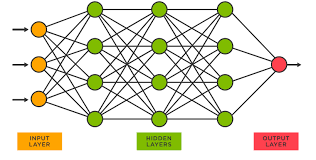

## Component of a neural network

- **Activation** function determine whether a neuron should be activated or not.  The computations that happen in a neuron network includes applying an activation function. If a neuron activates, then it mean the input is important.  The are different kinds of activation functions. The choice of which activation function use depends on what you want the output to be. 
- **Weights** influences how well an input will come close to the expected output value. As an input enters the neuron, it gets multiplied by a weight value and the resulting output is either observed, or passed to the next layer in the neural
- **bias**  make up the difference between the activation function's output and its intended output. A low bias suggest that the network is making more assumptions about the form of the output, whereas a high bias value makes less assumptions about the form of the output. 

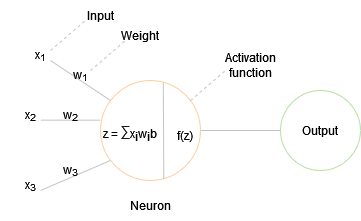

# Build a neural network

Neural networks comprise of layers/modules that perform operations on data. 
The [torch.nn](https://pytorch.org/docs/stable/nn.html) namespace provides all the building blocks you need to 
build your own neural network. Every module in PyTorch subclasses the [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). 
A neural network is a module itself that consists of other modules (layers). This nested structure allows for
building and managing complex architectures easily.

In the following sections, we'll build a neural network to classify images in the FashionMNIST dataset.

In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Get a hardware device for training

We want to be able to train our model on a hardware accelerator like the GPU, 
if it is available. Let's check to see if 
[torch.cuda](https://pytorch.org/docs/stable/notes/cuda.html) is available, else we 
continue to use the CPU.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Define the class

We define our neural network by subclassing `nn.Module`, and 
initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements
the operations on input data in the `forward` method.

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of `NeuralNetwork`, and move it to the `device`, and print 
it's structure.



In [5]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


To use the model, we pass it the input data. This executes the model's `forward`,
along with some [background operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866). 
Do not call `model.forward()` directly!

Calling the model on the input returns a 10-dimensional tensor with raw predicted values for each class.
We get the prediction densities by passing it through an instance of the `nn.Softmax` module.

In [6]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X) 
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([2], device='cuda:0')


## Model layers

Let's break down the layers in the FashionMNIST model. To illustrate it, we 
will take a sample minibatch of 3 images of size **28x28** and see what happens to it as 
we pass it through the network. 



In [7]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten

We initialize the [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) 
layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values (the minibatch dimension (at dim=0) is maintained). Each of the pixels are pass to the input layer of the neural network.  

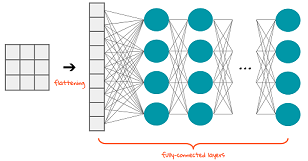

In [8]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear 

The [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
is a module that applies a linear transformation on the input using it's stored weights and biases.  The gayscale value of each pixel in the input layer will be connected to neurons in the hidden layer for calculation.    The calculation will be **_∑ weight * input + bias_**.


In [9]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU

Non-linear activations are what create the complex mappings between the model's inputs and outputs.
They are applied after linear transformations to introduce *nonlinearity*, helping neural networks
learn a wide variety of phenomena. In this model, we use [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) between our linear layers, but there's other activations to introduce non-linearity in your model.

The ReLU activation function takes the output from the linear layer calculation and replaces the negative values with zeros.

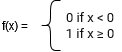

In [10]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.2190,  0.1448, -0.5783,  0.1782, -0.4481, -0.2782, -0.5680,  0.1347,
          0.1092, -0.7941, -0.2273, -0.4437,  0.0661,  0.2095,  0.1291, -0.4690,
          0.0358,  0.3173, -0.0259, -0.4028],
        [-0.3531,  0.2385, -0.3172, -0.4717, -0.0382, -0.2066, -0.3859,  0.2607,
          0.3626, -0.4838, -0.2132, -0.7623, -0.2285,  0.2409, -0.2195, -0.4452,
         -0.0609,  0.4035, -0.4889, -0.4500],
        [-0.3651, -0.1240, -0.3222, -0.1072, -0.0112, -0.0397, -0.4105, -0.0233,
         -0.0342, -0.5680, -0.4816, -0.8085, -0.3945, -0.0472,  0.0247, -0.3605,
         -0.0347,  0.1192, -0.2763,  0.1447]], grad_fn=<AddmmBackward>)


After ReLU: tensor([[0.2190, 0.1448, 0.0000, 0.1782, 0.0000, 0.0000, 0.0000, 0.1347, 0.1092,
         0.0000, 0.0000, 0.0000, 0.0661, 0.2095, 0.1291, 0.0000, 0.0358, 0.3173,
         0.0000, 0.0000],
        [0.0000, 0.2385, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2607, 0.3626,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2409, 0.000

### nn.Sequential

[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) is an ordered 
container of modules. The data is passed through all the modules in the same order as defined. You can use
sequential containers to put together a quick network like `seq_modules`.



In [11]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

### nn.Softmax

The last linear layer of the neural network returns `logits` - raw values in \[`-infty`, `infty`] - which are passed to the
[nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) module. The logits are scaled to values \[0, 1\] representing the model's predicted densities for each class. `dim` parameter indicates the dimension along which the values must sum to 1.

The Softmax activation function is used to calculate the probability of the output.  It is only used on the output layer of a neural network.  The sum of all the output nodes must be equal to 1.  The node with the highest probably should match the expected output.

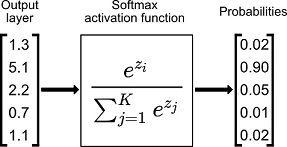

In [12]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

## Model parameters

Many layers inside a neural network are *parameterized*, i.e. have associated weights 
and biases that are optimized during training. Subclassing `nn.Module` automatically 
tracks all fields defined inside your model object, and makes all parameters 
accessible using your model's `parameters()` or `named_parameters()` methods.

In this example, we iterate over each parameter, and print its size and a preview of its values.


In [13]:
print("Model structure: ", model, "\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure:  NeuralNetwork(
  (flatten): Flatten()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
) 


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0320,  0.0326, -0.0032,  ..., -0.0236, -0.0025, -0.0175],
        [ 0.0180,  0.0271, -0.0314,  ..., -0.0094, -0.0170, -0.0257]],
       device='cuda:0', grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0134,  0.0036], device='cuda:0', grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0262,  0.0072, -0.0348,  ..., -0.0374,  0.0345,  0.0374],
        [ 0.0439, -0.0101,  0.0218,  ..., -0.0419,  0.0212, -0.0081]],
       device='cuda:0', grad_fn=<SliceBack

--------------


